## Plan-and-Execute
#### What is ReAct?
ReAct stands for Reasoning + Acting.
It’s a prompting framework that helps LLMs think and act step-by-step, similar to how humans reason before taking actions. It is a powerful framework that enhances the capabilities of LLMs by enabling them to not only reason through a problem but also to interact with and take actions in an external environment to gather more information. This synergistic approach allows LLMs to tackle complex, multi-step tasks with greater accuracy and reliability.

The core idea behind the ReAct framework is to mimic human problem-solving, where we often combine internal thought processes with external actions to find a solution. For instance, if asked a complex question you don't know the answer to, you might first think about what information you need (reasoning) and then perform a search on the internet (acting) to find that informatio

#### How ReAct Works: The Thought-Action-Observation Loop
The ReAct framework operates in a cyclical process involving three key components:

- **Thought:** The LLM analyzes the given prompt or question and breaks it down into a series of logical steps. It verbalizes its internal reasoning process, outlining its understanding of the problem and formulating a plan to solve it.

- **Action:** Based on its thought process, the LLM determines that it needs external information or needs to perform a specific task. It then decides to take an action, which typically involves using an external tool. This could be anything from performing a web search to querying a database or interacting with an API.

- **Observation:** The LLM receives the result or feedback from the action it took. This new information, or "observation," is then fed back into its reasoning process.

This thought-action-observation loop continues until the LLM has gathered enough information and has reasoned through the problem sufficiently to provide a final, comprehensive answer.
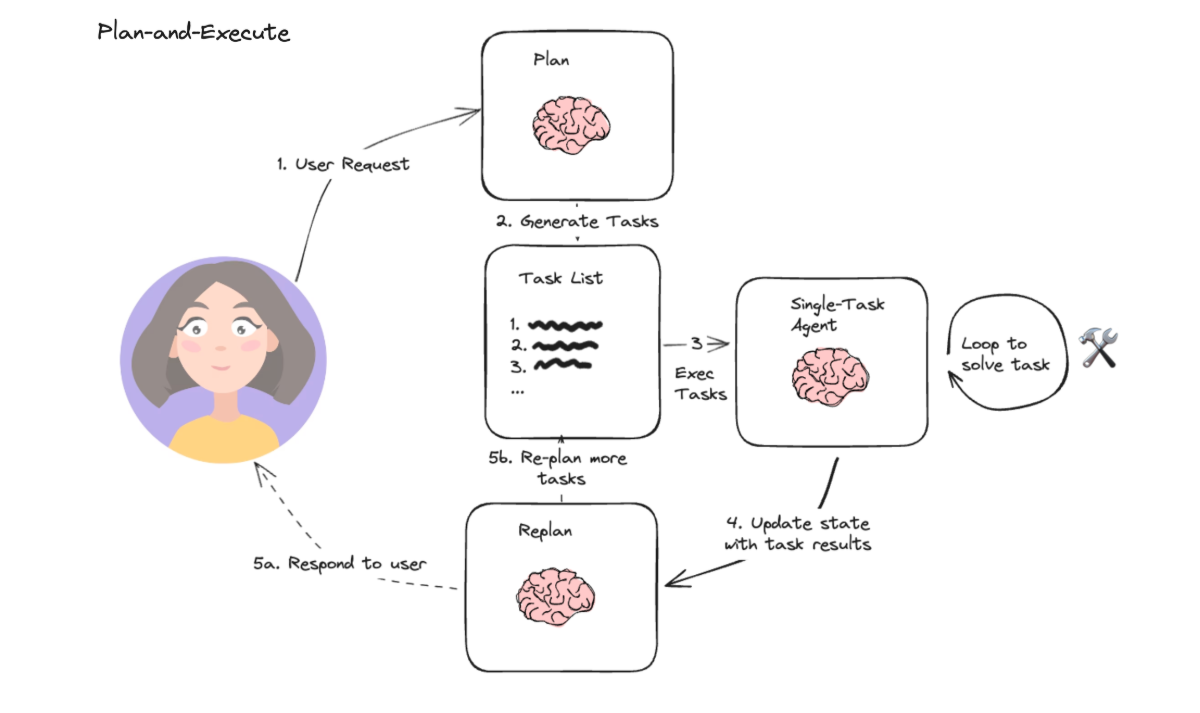

In [15]:
import os
from dotenv import load_dotenv,find_dotenv
_=load_dotenv(find_dotenv())
openai_api_key = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")


## Define Tools
We will first define the tools we want to use. For this simple example, we will use a built-in search tool via Tavily.

In [16]:

from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

C:\Users\Acer\AppData\Local\Temp\ipykernel_24164\2388402696.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tools = [TavilySearchResults(max_results=3)]


## Define our Execution Agent


In [17]:
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4-turbo-preview")
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [18]:
agent_executor.invoke({"messages": [("user", "who is the winnner of the us open")]})


{'messages': [HumanMessage(content='who is the winnner of the us open', additional_kwargs={}, response_metadata={}, id='73d0a3d9-68e0-4a5e-b193-1b09eb02f9c3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9bpIduLWUGmOl791ZtGiOsdP', 'function': {'arguments': '{"query": "us open 2023 winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_JcXbvDjgcMeEkVedhHqNdDM7', 'function': {'arguments': '{"query": "us open tennis 2023 winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_Mnh8DYzMne75NBpPAXMA8ora', 'function': {'arguments': '{"query": "us open golf 2023 winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 97, 'total_tokens': 183, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details':

## Define the State
Let's now start by defining the state the track for this agent.

First, we will need to track the current plan. Let's represent that as a list of strings.

Next, we should track previously executed steps. Let's represent that as a list of tuples (these tuples will contain the step and then the result)

Finally, we need to have some state to represent the final response as well as the original input.

In [19]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

## Planning Step


In [20]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [21]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

In [22]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Identify the current year to determine the most recent Australia Open winner.', 'Research the winner of the Australia Open for the current year.', 'Find the hometown of the identified winner from the Australia Open.'])

## Re-Plan Step


In [23]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

## Create the Graph


In [24]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i + 1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [25]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

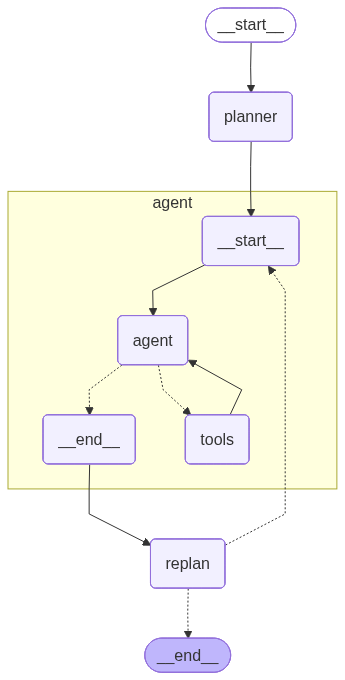

In [26]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ["Identify the winner of the men's 2024 Australian Open.", "Research the winner's personal background to find their hometown.", 'Verify the information from a reliable source to ensure accuracy.', "Conclude with the hometown of the men's 2024 Australian Open winner."]}
{'past_steps': [("Identify the winner of the men's 2024 Australian Open.", "The winner of the men's 2024 Australian Open is Jannik Sinner. He defeated Daniil Medvedev in the final.")]}
{'plan': ["Research Jannik Sinner's personal background to find his hometown.", 'Verify the information from a reliable source to ensure accuracy.', "Conclude with the hometown of the men's 2024 Australian Open winner."]}
{'past_steps': [("Research Jannik Sinner's personal background to find his hometown.", "Jannik Sinner's hometown is Sexten (also known as Sesto), located in the South Tyrol region of Northern Italy, along the Austrian border.")]}
{'response': "The plan has been successfully completed. The hometown of the men's 20

: 